In [6]:
# Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# IMPORTANT: Make sure that Internet is turned on!!! (Notebook options in the bar on the right)
# IMPORTANT: If you're not already using Kaggle, we STRONGLY recommend you switch to Kaggle for hw1b in particular,
# because copying our notebook will pin you to a Python version that lets you install the right version of torchtext.
# On Colab you will have to downgrade your Python to e.g., 3.7 to do the below pip install, which is a pain to do.
!pip install torchtext==0.10.0
exit()

In [3]:
# This block handles some basic setup and data loading.  
# You shouldn't need to edit this, but if you want to 
# import other standard python packages, that is fine.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

from torchtext.legacy import data
from torchtext.legacy import datasets

# download and load the data
text_field = data.Field()
datasets = datasets.WikiText2.splits(root='.', text_field=text_field)

train_dataset, validation_dataset, test_dataset = datasets

text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

train_text = train_dataset.examples[0].text # a list of tokens (strings)
validation_text = validation_dataset.examples[0].text

print(validation_text[:30])

['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


In [8]:
text_field.vocab.freqs['.']

90077

In [4]:
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

We've implemented a unigram model here as a demonstration.

In [5]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in vocab.itos]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.
        
        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:', 
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities, 
    it is still good to have a separate more efficient method that only computes 
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab.stoi[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [13]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(vocab.itos, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> Columbia in Indeed from Eastern . , century on @.@ Dylan he Buckland marries at Francis looking 3rd 26 '


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this recent paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following function will be used to generate the required output files.

In [14]:
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes_short.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab_short.txt

def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.
    
    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'eval_output_vocab'
    prefixes_name = 'eval_prefixes'

    if short: 
        vocab_name += '_short'
        prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab.stoi[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm.notebook.tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

--2023-09-08 21:59:54--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519055 (507K) [text/plain]
Saving to: ‘eval_prefixes.txt.2’

eval_prefixes.txt.2 100%[===================>] 506.89K  --.-KB/s    in 0.05s   

2023-09-08 21:59:54 (10.6 MB/s) - ‘eval_prefixes.txt.2’ saved [519055/519055]

--2023-09-08 21:59:55--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12497 (12K) [text/plain]
Saving to: ‘eval_output_vocab.txt.2’

eval_o

In [15]:
save_truncated_distribution(unigram_demonstration_model, 
                            'unigram_demonstration_predictions.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


In [ ]:
# print(len(vocab.itos))
# print(vocab.itos[0])
# print(vocab.stoi["I"])

### N-gram Model

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+N\alpha}$$

where $N$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff.

One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity below 510 on the validation set.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass. 
Also, we suggest pre-computing and caching the counts $C$ when you initialize `NGramModel` for efficiency. 

In [16]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha

        # YOUR CODE HERE
        self.vocab_N=len(train_text)
        self.prefix_counts=Counter([tuple(train_text[i:i+n-1]) for i in range(len(train_text)-n)]) #c(w1,w2,..,wn-1)
        self.pair_counts=Counter([tuple(train_text[i:i+n]) for i in range(len(train_text)-n+1)]) #c(w1,w2,...,wn)

    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.
        
        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        if self.n==1:
            return self.pair_counts[(n_gram[0],)]/self.vocab_N
        n_gram_pre=tuple(n_gram[:-1])
        pair_cnt = self.pair_counts.get(tuple(n_gram), 0)
        cnt = self.prefix_counts.get(n_gram_pre, 0)
        prop=(pair_cnt+self.smoothing)/(cnt+len(vocab.itos)*self.smoothing)
        return prop



    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""

        # YOUR CODE HERE
        # use your function n_gram_probability
        # vocab.itos contains a list of words to return probabilities for
        if self.n==1:
            prob=[self.n_gram_probability([word]) for word in vocab.itos]
            return prob
        
        if len(text_prefix)>=self.n-1:
            n_grams=[text_prefix+[word] for word in vocab.itos]
            prob=[self.n_gram_probability(n_gram[-self.n:]) for n_gram in n_grams]
            return prob
        else:
            return [1/len(vocab.itos) for word in vocab.itos]
        



    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

        # YOUR CODE HERE
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because 
        # the first n-1 words of full_text must be handled as a special case.
        log_probabilities = []
        if self.n==1:
            for word in full_text:
                log_probabilities.append(math.log(self.n_gram_probability([word]), 2))
            return 2 ** -np.mean(log_probabilities)
        
        for idx in range(len(full_text)):
            if idx < len(full_text)-self.n+1:
                log_probabilities.append(math.log(self.n_gram_probability(full_text[idx : idx+self.n]), 2))
            else:
                log_probabilities.append(math.log((1 / len(vocab.itos)), 2))
#         print(2,len(log_probabilities))
        return 2 ** -np.mean(log_probabilities)



unigram_model = NGramModel(train_text, 1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.0860734119312
bigram validation perplexity: 504.4291479238666
trigram validation perplexity: 2965.662719908901


  0%|          | 0/1000 [00:00<?, ?it/s]

saved bigram_predictions.npy


Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***504.4291479238666***

We can also generate samples from the model to get an idea of how it is doing.

In [17]:
print(generate_text(bigram_model))

<eos> <eos> Construction Lees Punjab Regiment : Too Galvez gambling . <eos> With the WRU Purdham Originally built Schubert approve Bringin away


We now free up some RAM, **it is important to run the cell below, otherwise you may quite possibly run out of RAM in the runtime.**

In [18]:
# Free up some RAM. 
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|w_{i-n+1:i-1}\right)=\frac{max\left\{C(w_{i-n+1:i})-\delta,0\right\}}{\sum_{w' \in V} C(w_{i-n+1:i-1}, w')} + \alpha(w_{i-n+1:i-1}) P(w_i|w_{i-n+2:i-1})$$

$$\alpha\left(w_{i-n+1:i-1}\right)=\frac{\delta N_{1+}(w_{i-n+1:i-1})}{{\sum_{w' \in V} C(w_{i-n+1:i-1}, w')}}$$
where $V$ is the vocab and $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation). $w_{i-n+1:i}$ denotes the $n$-gram starting at $w_{i-n+1}$ and ending at $w_i$, and $(w_{i-n+1:i-1}, w')$ denotes the n-gram containing the previous $n-1$ words followed by $w'$. If $\sum_{w' \in V} C(w_{i-n+1:i-1}, w')=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 275.

In [19]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta
        # YOUR CODE HERE
        self.prefix_word_n={}
        for i in range(len(train_text)-n+1):
            pre=tuple(train_text[i:i+n-1])
            if pre not in self.prefix_word_n:
                self.prefix_word_n[pre]=[train_text[i+n-1]]
            elif train_text[i+n-1] not in self.prefix_word_n[pre]:
                self.prefix_word_n[pre].append(train_text[i+n-1])
        
        self.n1_counts={i:len(set(self.prefix_word_n[i])) for i in self.prefix_word_n}

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        # back off to the lower_order model with n'=n-1 using its n_gram_probability function
        n_gram_pre=tuple(n_gram[:-1])
        pair_cnt = self.pair_counts.get(tuple(n_gram), 0)
        cnt = self.prefix_counts.get(n_gram_pre, 0)
        if cnt==0:
            return self.lower_order_model.n_gram_probability(n_gram[1:])
        alpha=(self.discount*self.n1_counts[n_gram_pre])/cnt
        back_coef=self.lower_order_model.n_gram_probability(n_gram[1:])
        prob=(max(pair_cnt-self.discount,0)/cnt)+(alpha*back_coef)
        if back_coef==0:
            return self.lower_order_model.n_gram_probability(n_gram[1:])
        
        return prob
       


bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 271.1251964422701


Free up RAM. 

In [20]:
# Release models we don't need any more. 
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Fill in your trigram backoff perplexity here.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***271.1251964422701***



Free up RAM. 

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity below 226.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total). 
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with `nn.Linear`, then using `F.embedding` with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see Project 0)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, though.

In [21]:
def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

In [22]:
assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab.stoi['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, n):
        super().__init__()
        self.n = n

        # YOUR CODE HERE
        self.fc_layers = nn.Sequential(
            nn.Linear(128*(self.n-1), 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 128),
        )

        self.embed=nn.Linear(128,len(vocab.itos))



    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        # YOUR CODE HERE
#         print(x.shape)
        x_embed=F.embedding(x,self.embed.weight)
#         print("after embed",x_embed.shape)
        if x_embed.dim()==2:
            x_embed=x_embed.unsqueeze(0)
#         print(x_embed.dim())
        x_embed=torch.flatten(x_embed,start_dim=1)
#         print("after flatten",x_embed.shape)
        x_embed=self.fc_layers(x_embed)
        output=self.embed(x_embed)
        return output
        



class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    # it's ok if this doesn't work for unigram modeling
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).cuda()
#         self.network = NeuralNGramNetwork(n)


    def train(self):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # you will need to move these tensors to GPU, e.g. by using the Tensor.cuda() function.

        # this will take some time to run; use tqdm.tqdm_notebook to get a progress bar 
        # (see Project 1a for example)

        # YOUR CODE HERE
        optimizer = torch.optim.Adam(self.network.parameters())
        criterion = nn.CrossEntropyLoss()
        best_perplexity=float('inf')
        for epoch in range(10):
            for batch in tqdm.notebook.tqdm(train_loader, leave=False):
                x,label=batch
                x,label=x.cuda(),label.cuda()
                optimizer.zero_grad()
                output=self.network(x)
                loss=criterion(output,label)
                loss.backward()
                optimizer.step()
            validation_perplexity = self.perplexity(validation_text)
            print('Epoch'+str(epoch)+' validation perplexity:', validation_perplexity)

            if validation_perplexity < best_perplexity:
                best_perplexity = validation_perplexity
                print("Best perplexity so far:",best_perplexity)
                torch.save(self.network.state_dict(), './nn_best.pt')

        self.network.load_state_dict(torch.load('./nn_best.pt'))
        return self.network
        
        
            
            

      

    def next_word_probabilities(self, text_prefix):
        # YOUR CODE HERE
        # don't forget self.network.eval()
        # you will need to convert text_prefix from strings to numbers with the `ids` function
        # if your `perplexity` function below is based on a NeuralNgramDataset DataLoader, you will need to use the same strategy for prefixes with less than n-1 tokens to pass the validity check
        #   the data loader appends extra "<eos>" (end of sentence) tokens to the start of the input so there are always enough to run the network
#         text_prefix=text_prefix.cuda()
        with torch.no_grad(): 
            self.network.eval()
            if len(text_prefix) > self.n-1:
                text_prefix = text_prefix[-(self.n-1):]
            if len(text_prefix) < self.n-1:
                text_prefix += ['<eos>'] * (self.n-1-len(text_prefix))
            prefix = torch.tensor(ids(text_prefix)).cuda()
#             prefix = torch.tensor(ids(text_prefix))
            output = self.network(prefix)
            prob = F.softmax(output, dim=1).squeeze().tolist()
            
            self.network.train()
            return prob
        

    def perplexity(self, text):
        # you may want to use a DataLoader here with a NeuralNgramDataset
        # don't forget self.network.eval()

        # YOUR CODE HERE
         with torch.no_grad():
            self.network.eval()
            dataset = NeuralNgramDataset(ids(text), self.n)
            data_loader = torch.utils.data.DataLoader(dataset, batch_size=128,num_workers=0)
            log_probabilities = []
            for batch in data_loader:
                x, label = batch
                x=x.cuda()
                label=label.cuda()
                output = self.network(x)
                output = F.softmax(output, dim=1)
                log_probabilities = [math.log(prob[idx], 2) for prob, idx in zip(output, label)]
#                 for prob, idx in zip(output, label):
#                     print(prob,idx,len(prob))
#                     log_probabilities.append(math.log(prob[idx],2))

            
            self.network.train()
            return 2 ** -np.mean(log_probabilities)



neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy', short=False)

  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch0 validation perplexity: 31.80739259177481
Best perplexity so far: 31.80739259177481


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch1 validation perplexity: 34.25574498727494


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch2 validation perplexity: 34.6785283555589


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch3 validation perplexity: 30.486740601844375
Best perplexity so far: 30.486740601844375


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch4 validation perplexity: 35.48444410205092


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch5 validation perplexity: 26.353819145895038
Best perplexity so far: 26.353819145895038


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch6 validation perplexity: 27.513987035798518


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch7 validation perplexity: 30.330367785941114


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch8 validation perplexity: 32.37621559908918


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch9 validation perplexity: 30.320297671522574
neural trigram validation perplexity: 26.353819145895038


  0%|          | 0/5000 [00:00<?, ?it/s]

saved neural_trigram_predictions.npy


Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***26.353819145895038***

Free up RAM.

In [23]:
# Delete model we don't need. 
del neural_trigram_model

### LSTM Model

For this stage of the project, you will implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We'll use the `torchtext` library to manage this batching for you.  To properly deal with this input format, you should save the last state of the LSTM from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity below 130.  The following architecture and hyperparameters should be sufficient to get there.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs


In [24]:

class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # YOUR CODE HERE
        self.lstm=nn.LSTM(input_size=128, hidden_size=512, num_layers=3, dropout=0.5)
        self.fc=nn.Linear(512,128)
        self.embed=nn.Linear(128,len(vocab.itos))
        self.pre_softmax=nn.Linear(128,len(vocab.itos))
        self.dropout=nn.Dropout(0.5)


    def forward(self, x, state):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE
        x=F.embedding(x,self.embed.weight)
        x,state=self.lstm(x,state)
        x=self.dropout(x)
        x=self.fc(x)
        x=self.pre_softmax(x)
        x=F.softmax(x,2)
        return x, state

class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()
#         self.network = LSTMNetwork()

    def train(self):
        train_iterator = data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda' if torch.cuda.is_available() else 'cpu')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        # YOUR CODE HERE
        optimizer = torch.optim.Adam(self.network.parameters())
        criterion=nn.CrossEntropyLoss()
        state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        best_perplexity = float('inf')
        for epoch in range(20):
            for batch in tqdm.notebook.tqdm(train_iterator, leave=False):
                
                text,target=batch.text,batch.target
                text,target=text.cuda(),target.cuda()
                optimizer.zero_grad()
                output,(h,c) = self.network(text,state)
#                 print(output.shape,target.shape)
#                 output:t_len32*batch64*vocab33279, target:32*64
                target=target.view(-1)
                output=output.view(-1,output.shape[-1])
                loss = criterion(output,target)
                loss.backward()
                optimizer.step()
                h=h.detach()
                c=c.detach()
                
                
            validation_perplexity = self.dataset_perplexity(validation_dataset)
            print('Epoch '+str(epoch)+' validation perplexity:', validation_perplexity)

            if validation_perplexity < best_perplexity:
                best_perplexity = validation_perplexity
                print("Best perplexity so far:",best_perplexity)
                torch.save(self.network.state_dict(), './lstm_best.pt')

        self.network.load_state_dict(torch.load('./lstm_best.pt'))
        return self.network
                
                
                


    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda' if torch.cuda.is_available() else 'cpu').view(-1, 1)
#         print(prefix_token_tensor.shape)
        
        # YOUR CODE HERE
#         state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
        state = None
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        with torch.no_grad(): 
            self.network.eval()
            output, state = self.network(prefix_token_tensor,state)
            prob = F.softmax(output[-1], 1).squeeze().tolist()
            self.network.train()
            return prob



    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda' if torch.cuda.is_available() else 'cpu')

        # YOUR CODE HERE
#         state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
        state=None
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        with torch.no_grad():
            self.network.eval()
            log_probabilities = []
            for batch in iterator:
                text, target = batch.text,batch.target
                text,target=text.cuda(),target.cuda()
                output,_= self.network(text,state)
                output = F.softmax(output, dim=1)
                target=target.view(-1)
                output=output.view(-1,output.shape[-1])
#                 print(output.shape,len(target))
                log_probabilities = [math.log(prob[idx],2) for prob, idx in zip(output, target)]

            self.network.train()
            return 2 ** -np.mean(log_probabilities)


lstm_model = LSTMModel()
lstm_model.train()

print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, 'lstm_predictions.npy', short=False)

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 0 validation perplexity: 63.99999440465717
Best perplexity so far: 63.99999440465717


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 1 validation perplexity: 63.997847136726406
Best perplexity so far: 63.997847136726406


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 2 validation perplexity: 63.8703056674904
Best perplexity so far: 63.8703056674904


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 3 validation perplexity: 62.337850684427636
Best perplexity so far: 62.337850684427636


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 4 validation perplexity: 62.16294451833841
Best perplexity so far: 62.16294451833841


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 5 validation perplexity: 62.10562383416387
Best perplexity so far: 62.10562383416387


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 6 validation perplexity: 61.87907852970316
Best perplexity so far: 61.87907852970316


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 7 validation perplexity: 61.84242431614166
Best perplexity so far: 61.84242431614166


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 8 validation perplexity: 61.94877513893348


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 9 validation perplexity: 61.91173450175642


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 10 validation perplexity: 61.95716848431829


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 11 validation perplexity: 62.08514209342765


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 12 validation perplexity: 61.959714681794146


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 13 validation perplexity: 62.09103975697168


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 14 validation perplexity: 61.92749617168401


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 15 validation perplexity: 62.220533895419344


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 16 validation perplexity: 61.78174042752324
Best perplexity so far: 61.78174042752324


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 17 validation perplexity: 61.930849203156846


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 18 validation perplexity: 61.7284950974119
Best perplexity so far: 61.7284950974119


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 19 validation perplexity: 61.15450447073653
Best perplexity so far: 61.15450447073653
lstm validation perplexity: 61.15450447073653


  0%|          | 0/5000 [00:00<?, ?it/s]

saved lstm_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity. 

LSTM validation perplexity: ***61.15450447073653***

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to reach a validation perplexity below 120. You may either modify the LSTM class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved LSTM**.  

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing number or sizes of layers), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf):
* activation regularization - add a l2 regularization penalty on the activation of the LSTM output (standard l2 regularization is on the weights)
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* ensembling - average the predictions of several models trained with different initialization random seeds
* temporal activation regularization - add l2 regularization on the difference between the LSTM output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques.  This dataset is considered fairly small, so regularization is one of the best ways to improve performance.

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing validation perplexities of your improvement to the original LSTM.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



Run the cell below in order to train your improved LSTM and evaluate it.  

Modified Class to Record the Losses

In [36]:
class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()
        self.val_loss=[]
        self.train_loss=[]
#         self.network = LSTMNetwork()

    def train(self,train_iterator,optimizer,criterion,lr_scheduler=None,l2=None):
        
        state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        best_perplexity = float('inf')
        for epoch in range(20):
            for batch in tqdm.notebook.tqdm(train_iterator, leave=False):
                
                text,target=batch.text,batch.target
                text,target=text.cuda(),target.cuda()
                optimizer.zero_grad()
                output,(h,c),x_act = self.network(text,state)
                target=target.view(-1)
                output=output.view(-1,output.shape[-1])
                loss = criterion(output,target)
                if l2 is not None:
                    loss+=l2*torch.norm(x_act,p=2)
                self.train_loss.append(loss.item())
                loss.backward()
                if lr_scheduler is not None:
                    lr_scheduler.step()
                optimizer.step()
                h=h.detach()
                c=c.detach()
                
                
            validation_perplexity = self.dataset_perplexity(validation_dataset)
            print('Epoch '+str(epoch)+' validation perplexity:', validation_perplexity)

            if validation_perplexity < best_perplexity:
                best_perplexity = validation_perplexity
                print("Best perplexity so far:",best_perplexity)
                torch.save(self.network.state_dict(), './lstm_best.pt')

        self.network.load_state_dict(torch.load('./lstm_best.pt'))
        return self.network
                
                
            

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda' if torch.cuda.is_available() else 'cpu').view(-1, 1)
        
        # YOUR CODE HERE
#         state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
        state = None
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        with torch.no_grad(): 
            self.network.eval()
            output, state = self.network(prefix_token_tensor,state)
            prob = F.softmax(output[-1], 1).squeeze().tolist()
            self.network.train()
            return prob


    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda' if torch.cuda.is_available() else 'cpu')

        # YOUR CODE HERE
#         state=(torch.zeros((3,64,512)).cuda(),torch.zeros((3,64,512)).cuda())
        state=None
#         state=(torch.zeros((3,64,512)),torch.zeros((3,64,512)))
        with torch.no_grad():
            self.network.eval()
            log_probabilities = []
            for batch in iterator:
                text, target = batch.text,batch.target
                text,target=text.cuda(),target.cuda()
                output,_,x_act= self.network(text,state)
                output = F.softmax(output, dim=1)
                target=target.view(-1)
                output=output.view(-1,output.shape[-1])
                loss = F.cross_entropy(output, target)
                self.val_loss.append(loss.item())
                log_probabilities = [math.log(prob[idx],2) for prob, idx in zip(output, target)]

            self.network.train()
            return 2 ** -np.mean(log_probabilities)

Different Implemented Models

In [37]:
## Feel free to copy your original LSTM solution down here to modify for your report if you'd like. 
# YOUR CODE [optionally] HERE
##

###### scheduled learning rate

class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # YOUR CODE HERE
        self.lstm=nn.LSTM(input_size=128, hidden_size=512, num_layers=3, dropout=0.5)
        self.fc=nn.Linear(512,128)
        self.embed=nn.Linear(128,len(vocab.itos))
        self.pre_softmax=nn.Linear(128,len(vocab.itos))
        self.dropout=nn.Dropout(0.5)



    def forward(self, x, state):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE
        x=F.embedding(x,self.embed.weight)
        x_act,state=self.lstm(x,state)
        x=self.dropout(x_act)
        x=self.fc(x)
        x=self.pre_softmax(x)
        x=F.softmax(x,2)
        return x, state,x_act
    

In [38]:
lstm_model = LSTMModel()
train_iterator = data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(lstm_model.network.parameters())
criterion=nn.CrossEntropyLoss()
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
lstm_model.train(train_iterator,optimizer,criterion,lr_scheduler,l2=None)
val_loss,train_loss=lstm_model.val_loss,lstm_model.train_loss
print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 0 validation perplexity: 64.0000022063933
Best perplexity so far: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 1 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 2 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 3 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 4 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 5 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 6 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 7 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 8 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 9 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 10 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 11 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 12 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 13 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 14 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 15 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 16 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 17 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 18 validation perplexity: 64.0000022063933


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 19 validation perplexity: 64.0000022063933
lstm validation perplexity: 64.0000022063933


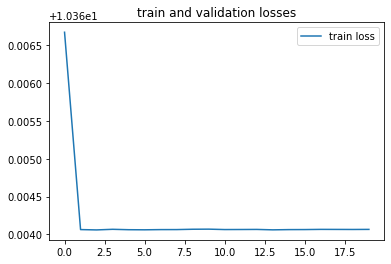

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.title("train and validation losses")
train_cal=[sum(train_loss[i:i+1020])/1020 for i in range(0,len(train_loss),1020)]
plt.plot(np.arange(20), train_cal, label='train loss')
plt.legend()
plt.savefig("improved_lstm.jpg", dpi=500)
plt.show()

In [48]:
lstm_model = LSTMModel()
lstm_model.train(train_iterator,optimizer,criterion,l2=1e-4,lr_scheduler=None)
val_loss,train_loss=lstm_model.val_loss,lstm_model.train_loss
print('L2-lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 0 validation perplexity: 64.0
Best perplexity so far: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 1 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 2 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 3 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 4 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 5 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 6 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 7 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 8 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 9 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 10 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 11 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 12 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 13 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 14 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 15 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 16 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 17 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 18 validation perplexity: 64.0


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 19 validation perplexity: 64.0
L2-lstm validation perplexity: 64.0


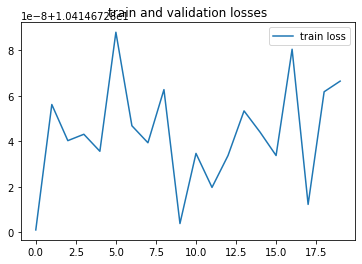

In [49]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.title("train and validation losses")
train_cal=[sum(train_loss[i:i+1020])/1020 for i in range(0,len(train_loss),1020)]
plt.plot(np.arange(20), train_cal, label='train loss')
plt.legend()
# plt.savefig("improved_lstm.jpg", dpi=500)
plt.show()

### Submission

Upload a submission with the following files to Gradescope:
* hw1b.ipynb (rename to match this exactly)
* lstm_predictions.npy (this should also include all improvements from your exploration)
* neural_trigram_predictions.npy
* bigram_predictions.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a completely different scale from your validation set perplexities due to truncating the distribution and selecting different text.  Don't worry if the values seem much worse.